In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import madmom

import sys
sys.path.append('../src')
from preprocessing import get_dataset, load_rhythm_feature_db
from models import OLSPatchRegressor
from utils import cv
import visualize

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
from sklearn.metrics import log_loss

MUSIC = 1
SPEECH = 0

na = np.newaxis

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


# --------------- FLAGS ----------
DATA = "SPECTRO" # "SPECTRO"
MODEL = "CNN"

assert DATA in ["RHYTHM", "SPECTRO"]
assert MODEL in ["CNN", "Linear"]


/home/niels/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
music_dir  = '../data/music_speech/music_wav/'
speech_dir = '../data/music_speech/speech_wav/'


def get_spectro_data():

    max_samples = -1

    X, Y = get_dataset(music_dir, speech_dir, hpool=0, wpool=0, 
                       num_samples=max_samples, shuffle=True, reload=False,
                       window=np.hanning, fps=100, num_bands=3, fmin=30, fmax=17000,
                       fft_sizes=[1024, 2048, 4096]
                      )
    print('Train Set Shape')
    print(X.shape, Y.shape)

    Y = (Y + 1) / 2 
    return X, Y
 

def get_rhythm_data():

    X, Y = load_rhythm_feature_db(music_dir, speech_dir, num_samples=-1)

    # change -1, 1 labels to 0,1
    Y = (Y + 1) / 2 

    # X is in (N,L,D) format

    X = X[:,na,:,:] # dont conv over the number of models
    return X, Y

X, Y = get_rhythm_data() if DATA == "RHYTHM" else get_spectro_data()

batch_size = 8
num_classes = 2
epochs = 100

# --------------------------------------------
num_frequencies = X.shape[1]
num_timesteps   = X.shape[2]
num_channels    = X.shape[3]
filter_time_size = 3
input_shape = num_frequencies, num_timesteps, num_channels



loaded from disk: -data-music_speech-music_wav--data-music_speech-speech_wav-_raw
Train Set Shape
(128, 24, 3000, 3) (128,)


In [3]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

CNN = None
def get_cnn(input_shape=(input_shape), reinit=False):
    global CNN
    if CNN is None:
        
        # DEFINE MODEL
        model = Sequential()
        model.add(MaxPooling2D(pool_size=(1, 3), input_shape=input_shape))
        model.add(Conv2D(32, kernel_size=(num_frequencies, filter_time_size),
                         activation='relu'))

        model.add(Conv2D(1, kernel_size=(1, 1), activation='sigmoid'))
        model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        CNN = model
        
        return model
    
    else:
        model = CNN
        reset_weights(model)
        return model

LINEAR = None
def get_linear(input_shape=(input_shape), reinit=False):
    global LINEAR
    if LINEAR is None:
        
        # DEFINE MODEL
        model = Sequential()
        model.add(Conv2D(1, kernel_size=(num_frequencies, filter_time_size),
                         activation='sigmoid',
                         input_shape=input_shape))

        model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        LINEAR = model
        
        return model
    
    else:
        model = LINEAR
        reset_weights(model)
        return model

get_model = get_cnn if MODEL == "CNN" else get_linear


train_model = lambda model, X, Y: model.fit(X, Y,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        verbose=0)

In [4]:
# load model
split = 100
Xtrain, Ytrain, Xtest, Ytest = X[:split], Y[:split], X[split:], Y[split:]
model_dir = '../models/keras/'
model_path = os.path.join(model_dir, '{}_on_{}-filter{}-evaluation.h5'.format(MODEL.lower(), DATA.lower(), filter_time_size))
# evaluate using train-test split
model = get_model()
try:
    model.load_weights(model_path)
    print("loaded model")
except OSError:
    print("train model")
    train_model(model, Xtrain, Ytrain)
    
    os.makedirs(model_dir, exist_ok=True)

    model.save(model_path)

loaded model


In [5]:
score = model.evaluate(Xtest, Ytest, verbose=0)
print("Score", score)

Score [0.3578074872493744, 0.8928571343421936]


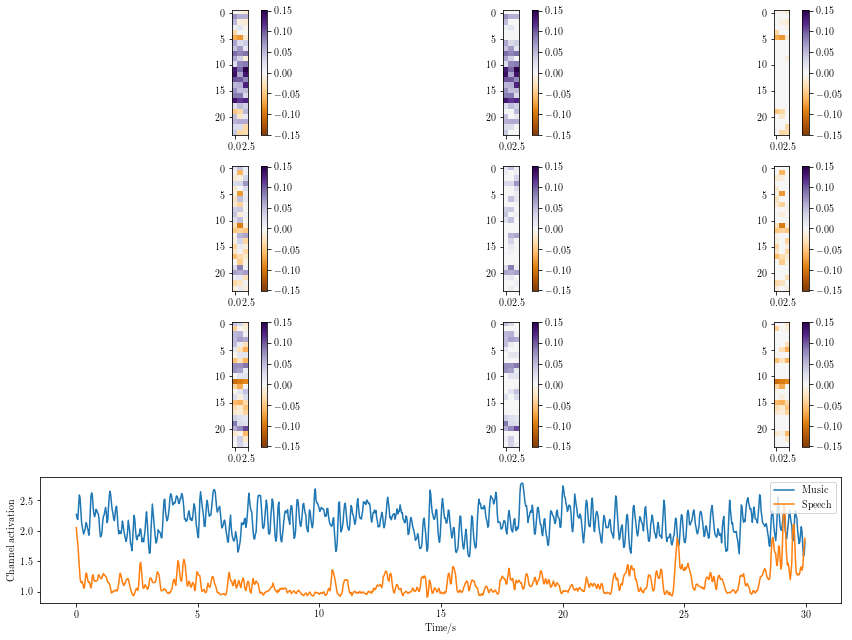

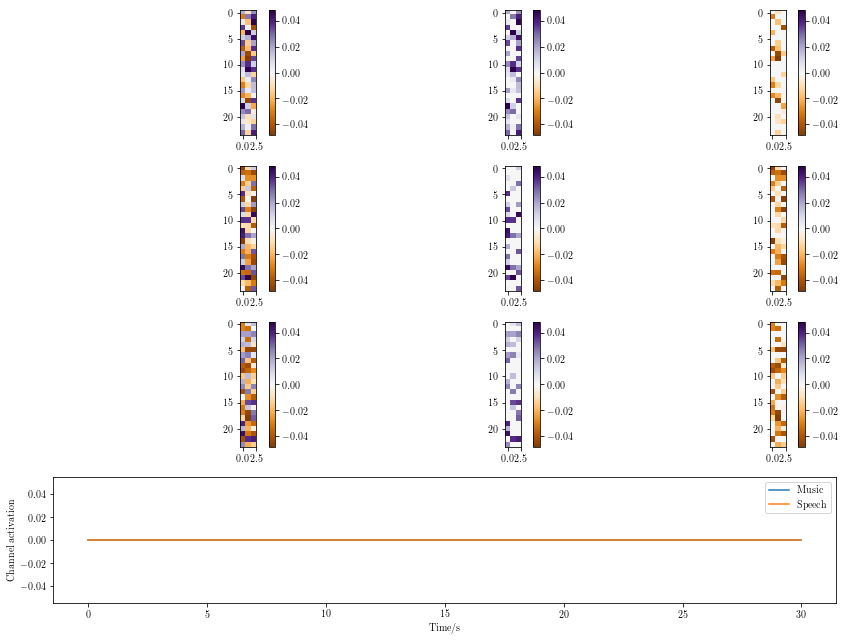

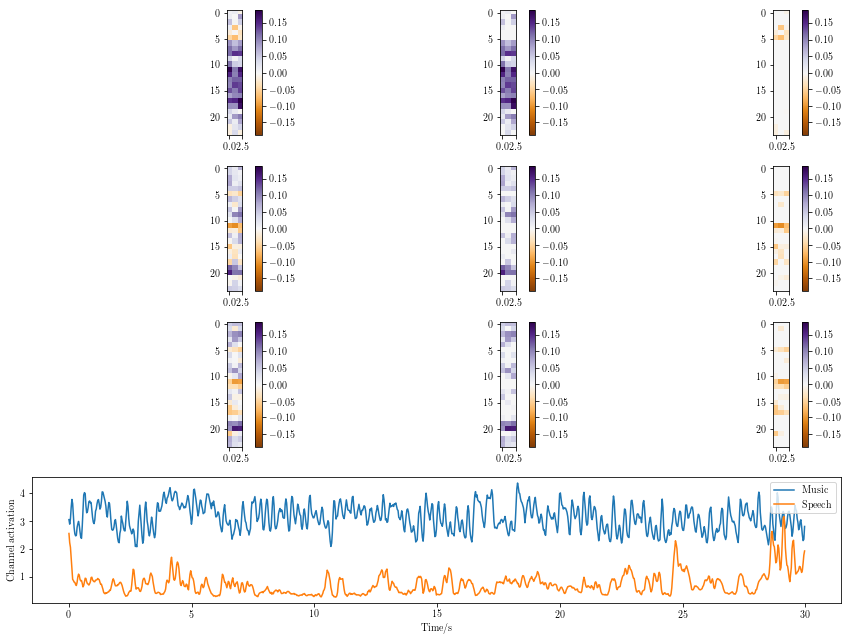

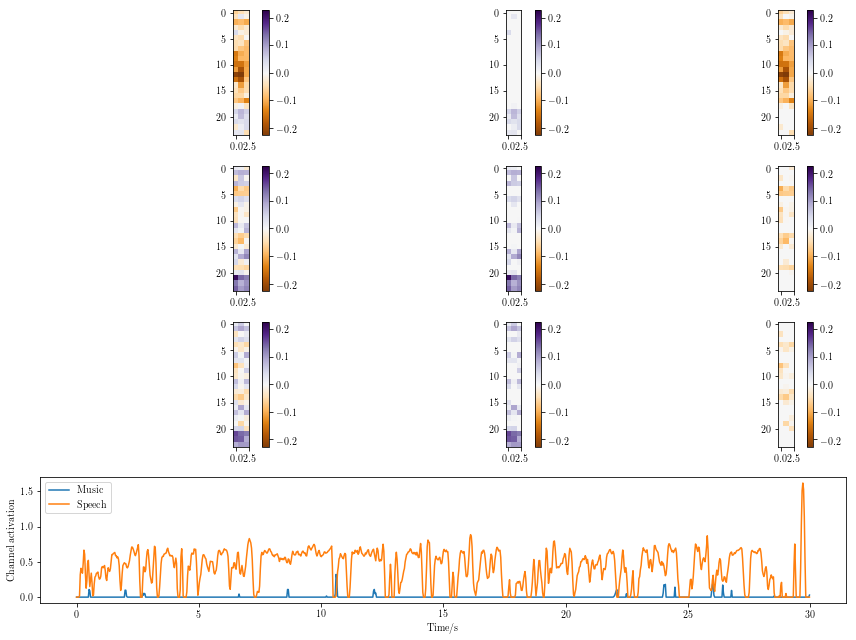

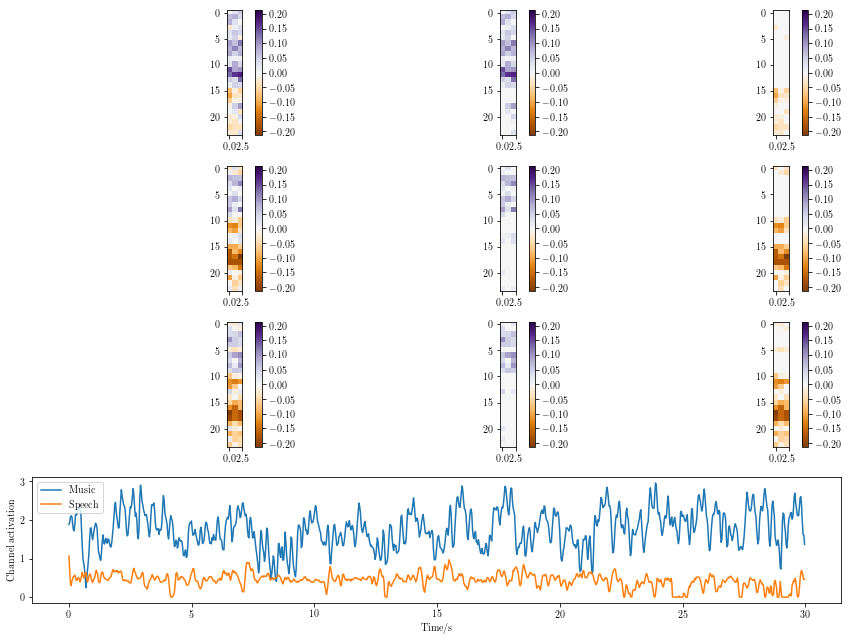

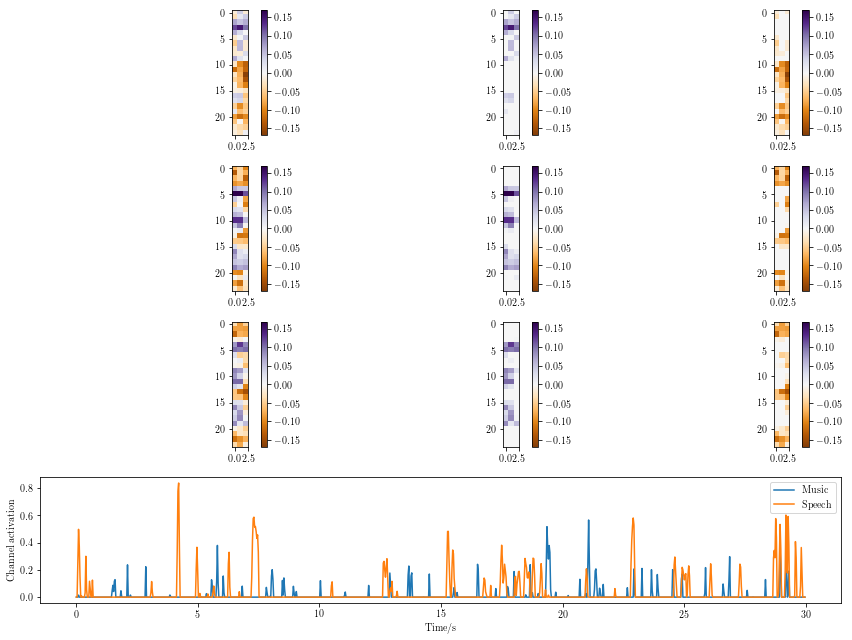

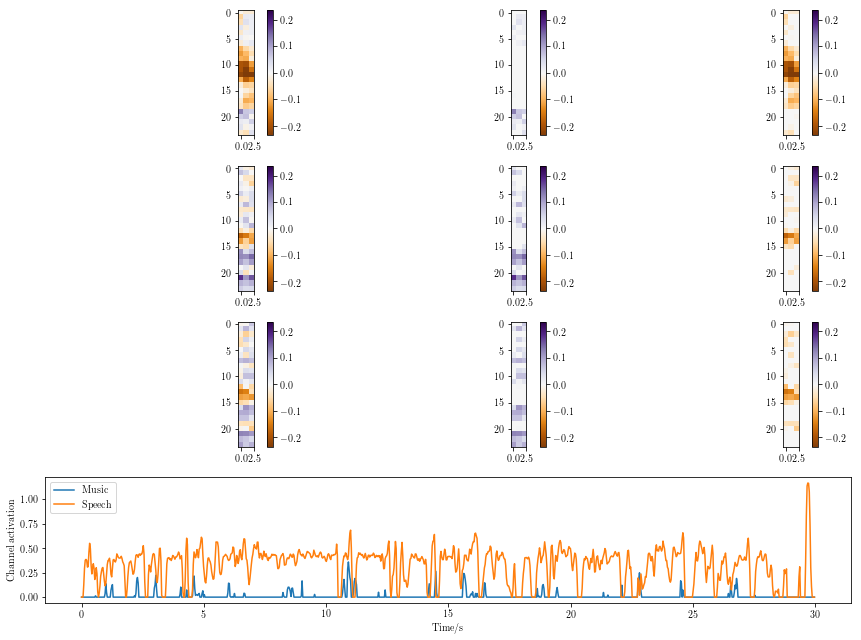

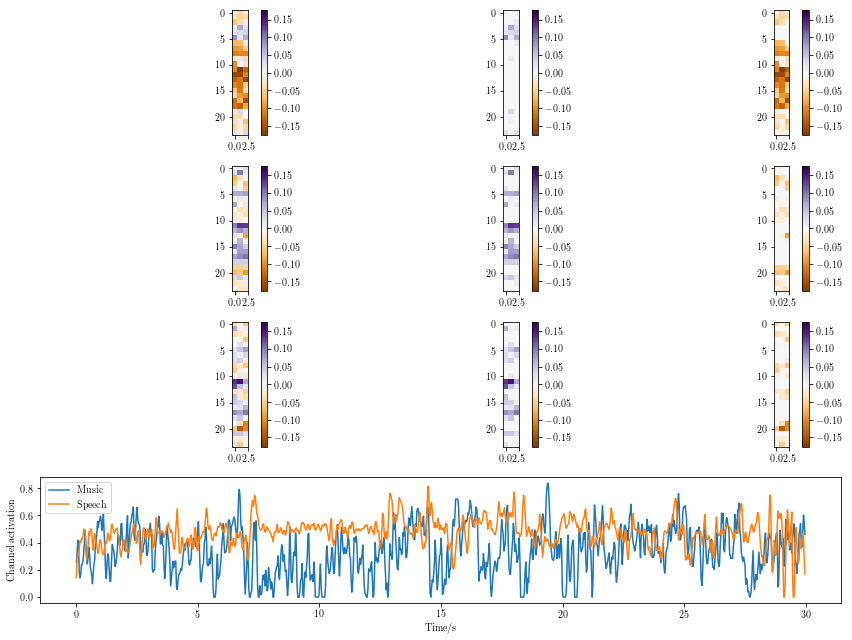

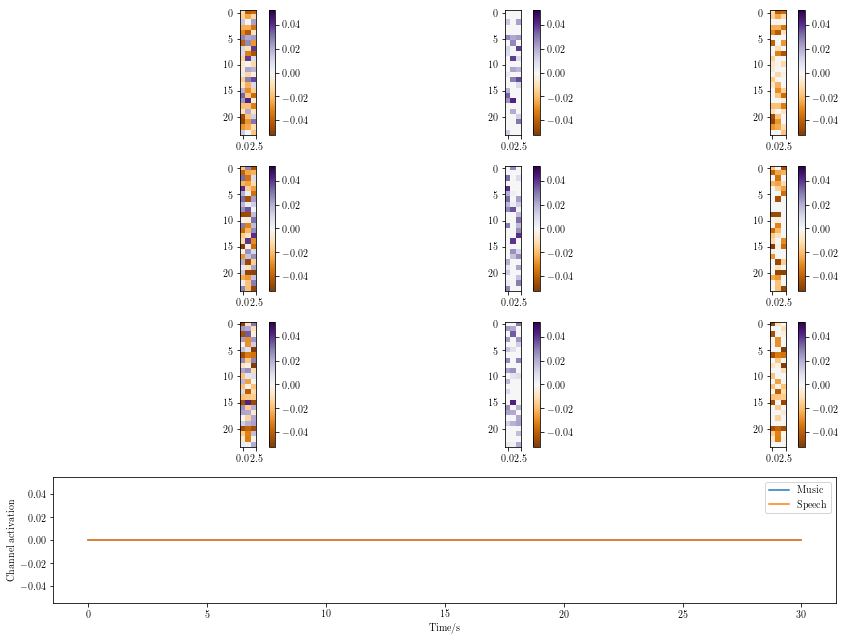

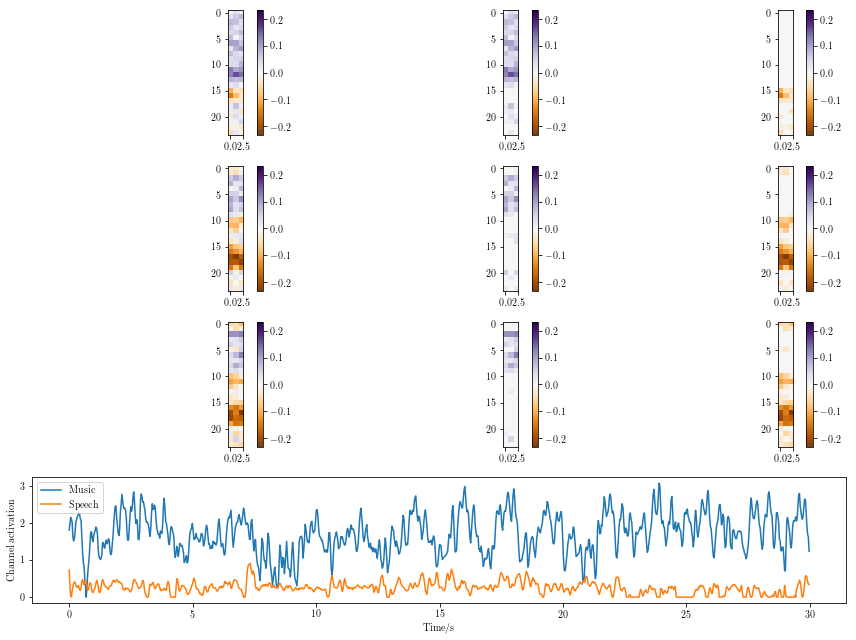

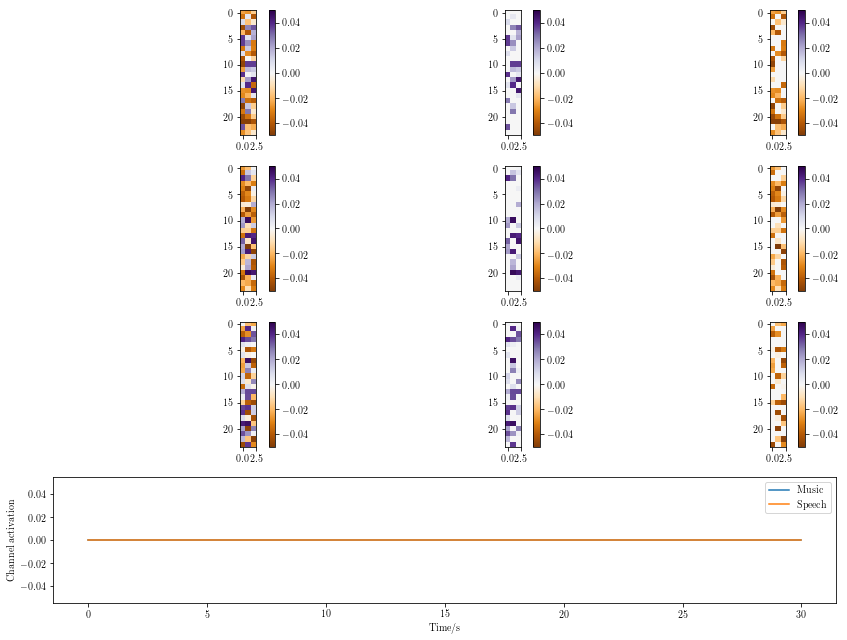

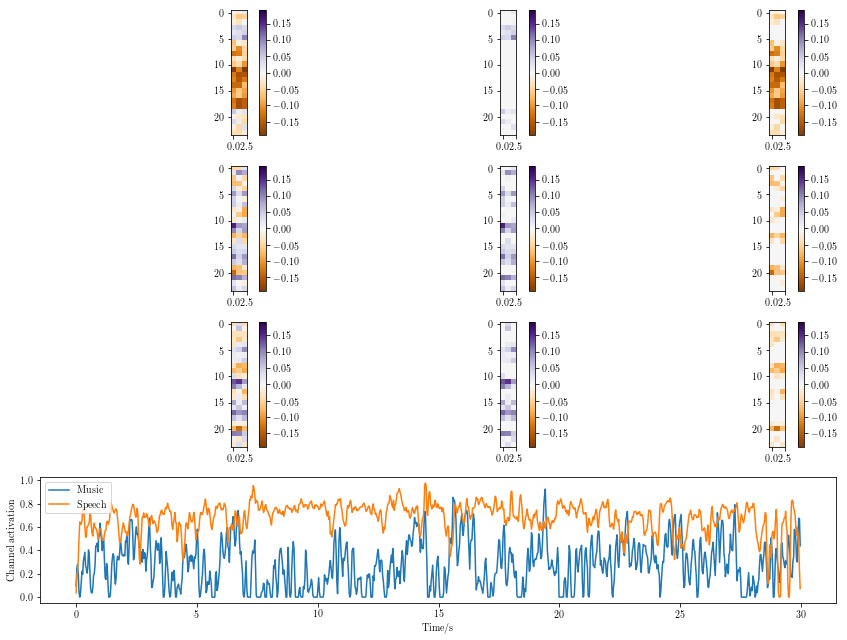

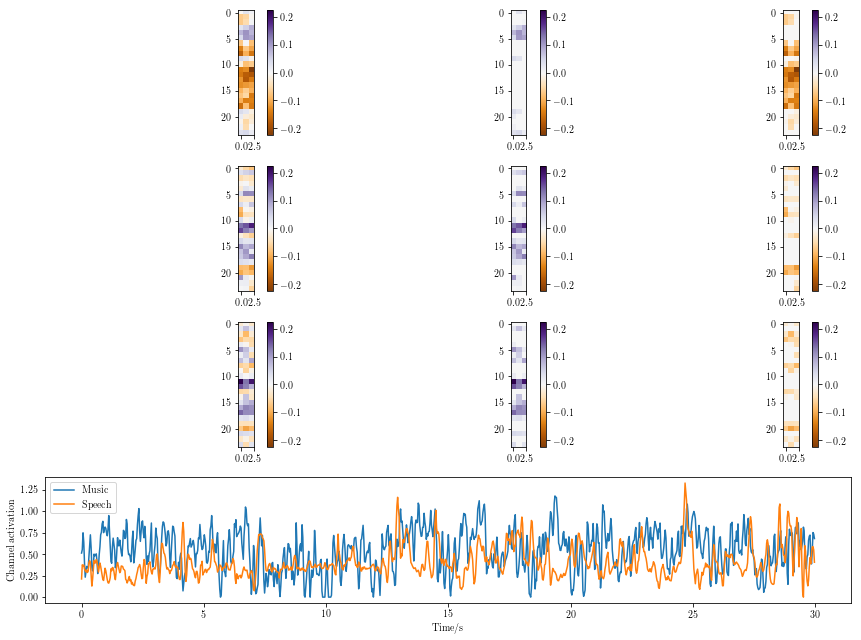

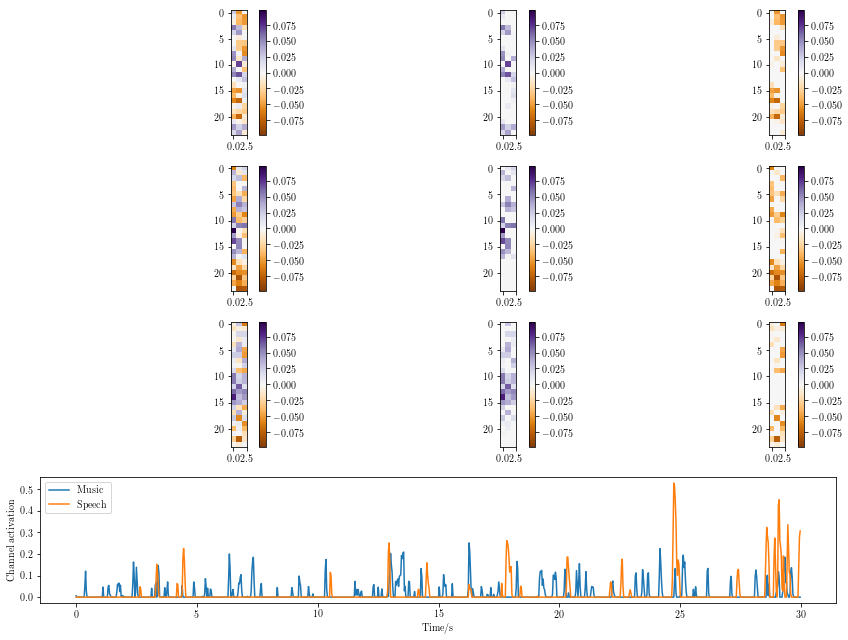

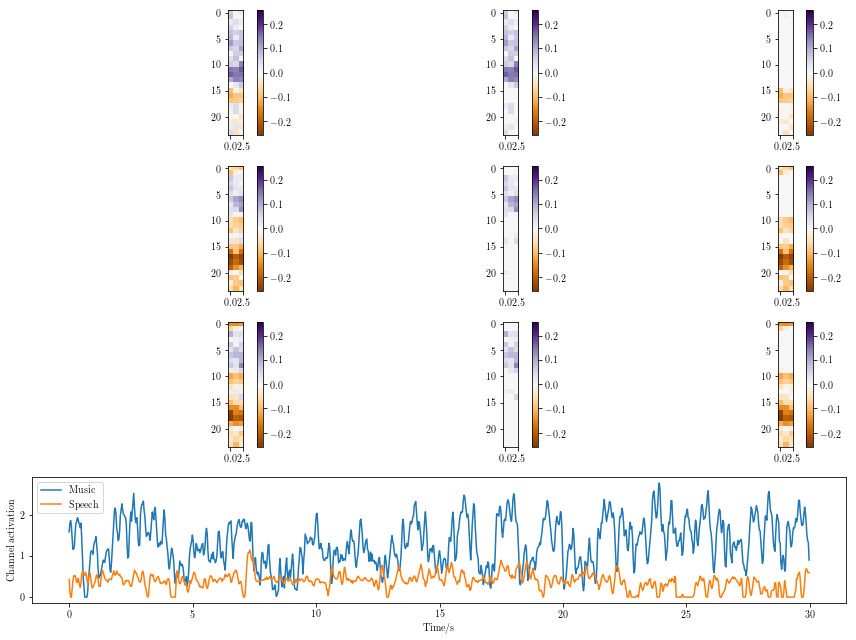

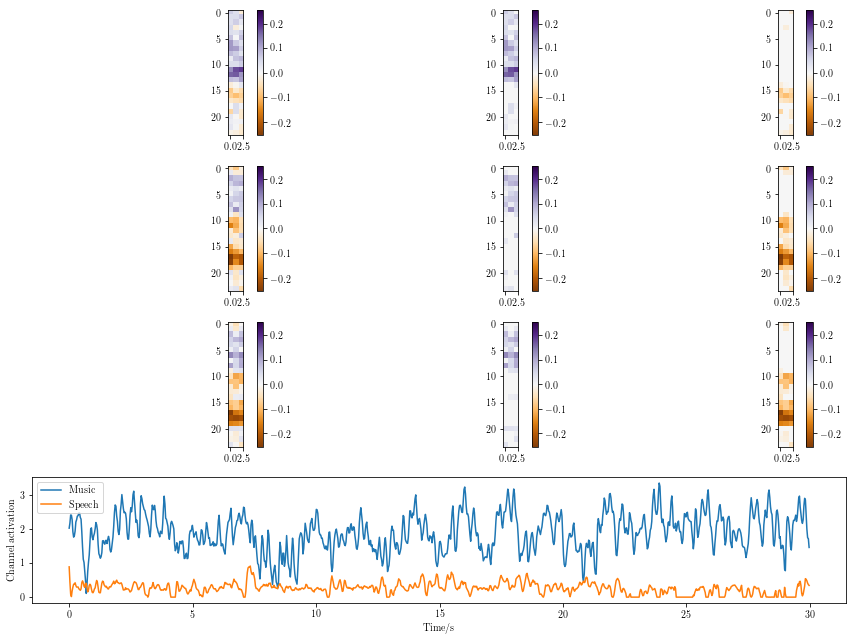

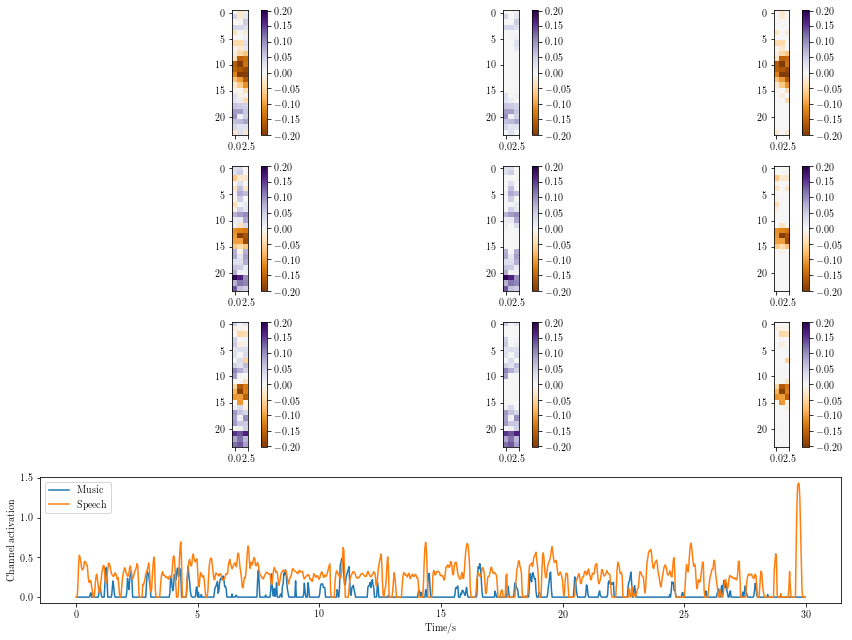

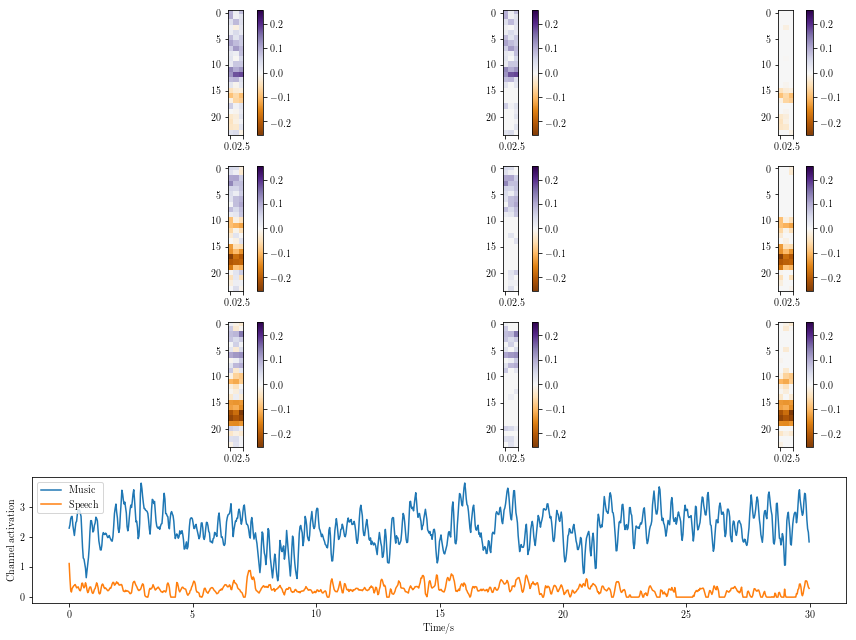

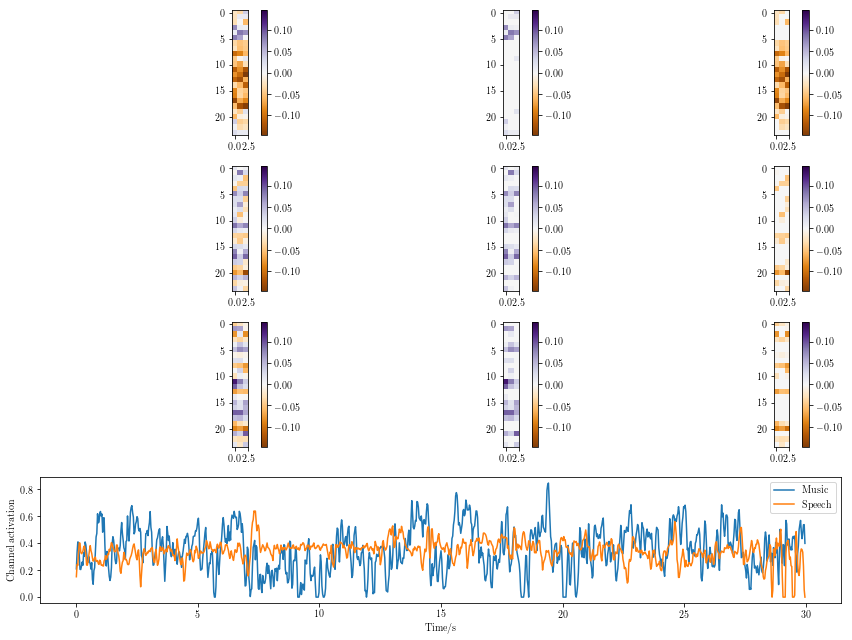

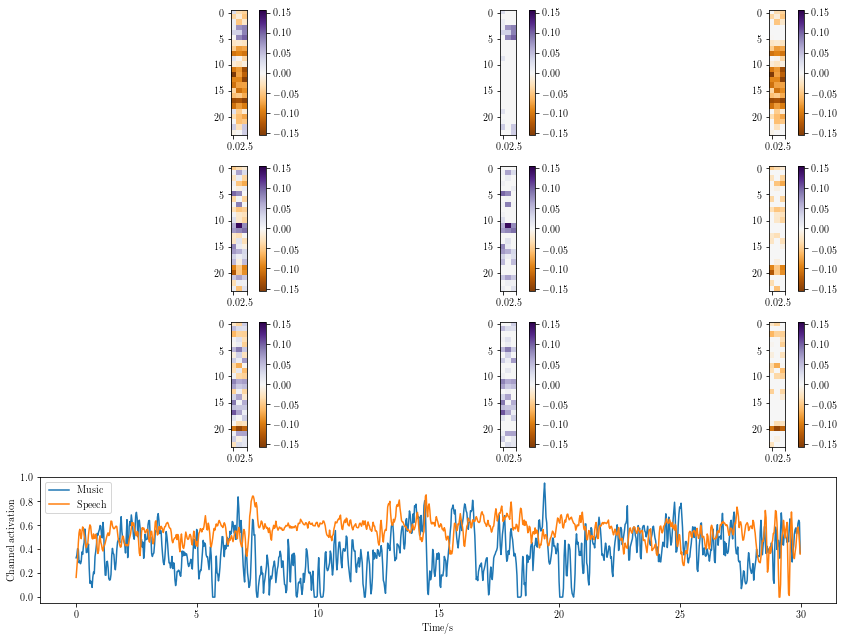

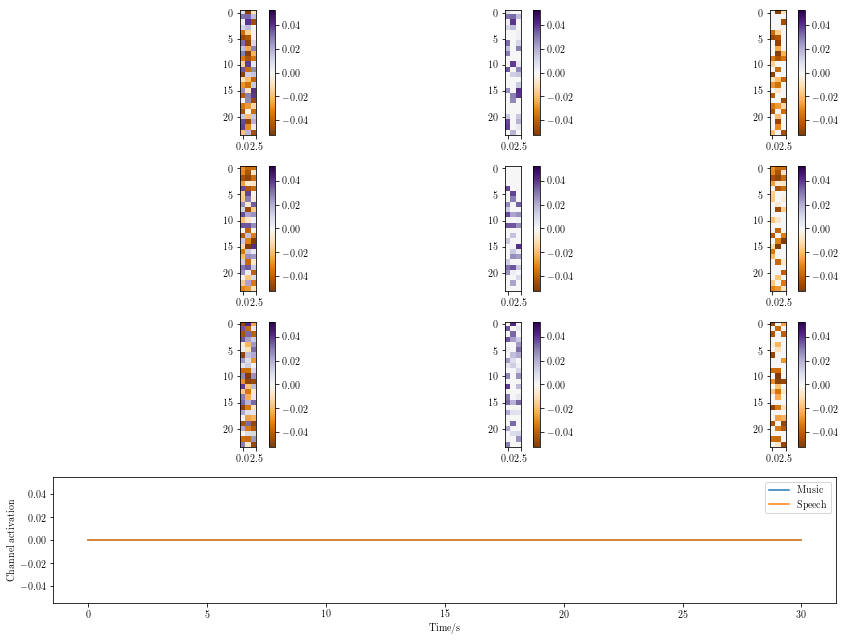

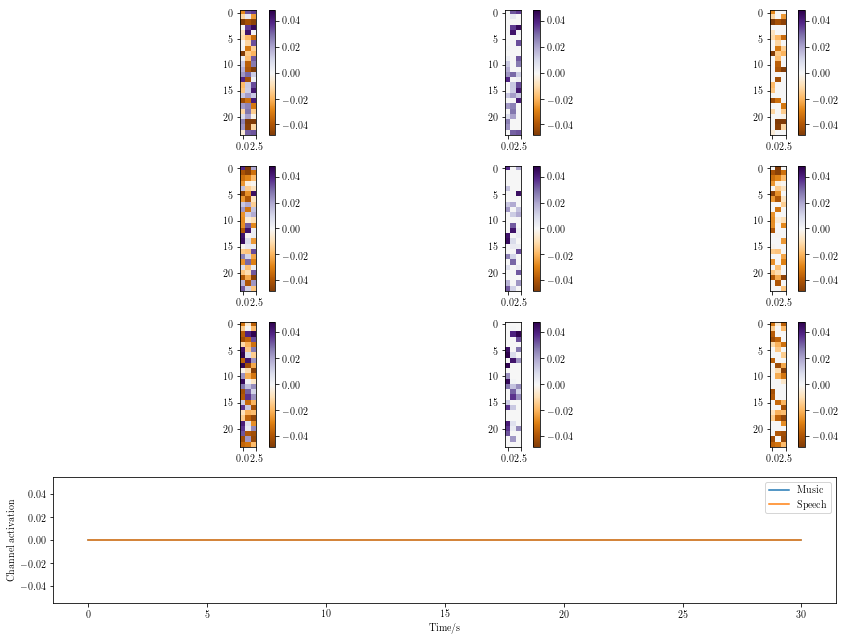

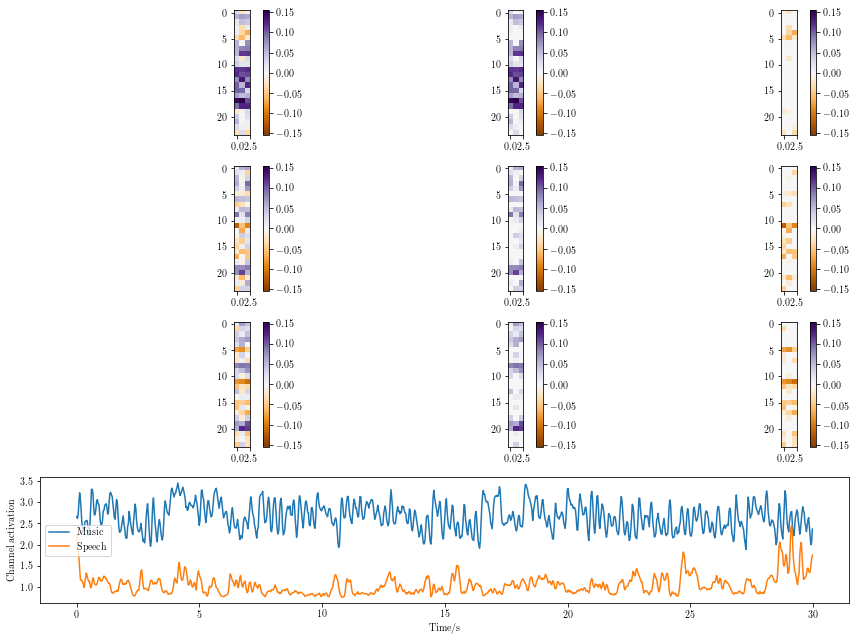

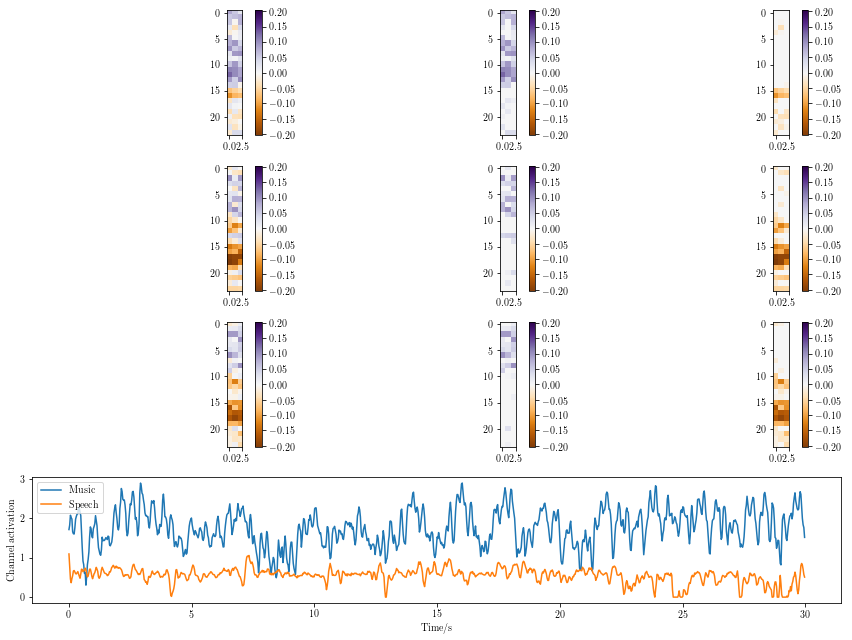

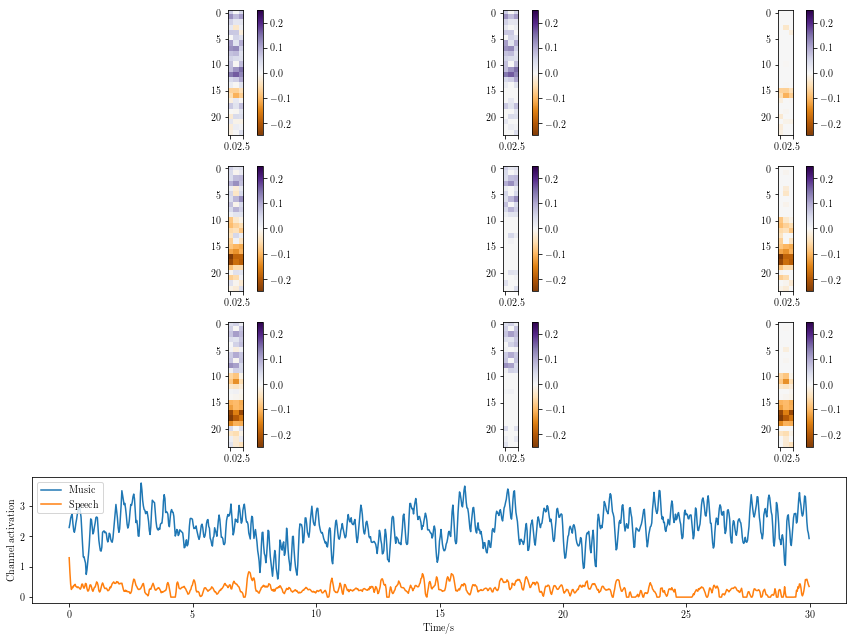

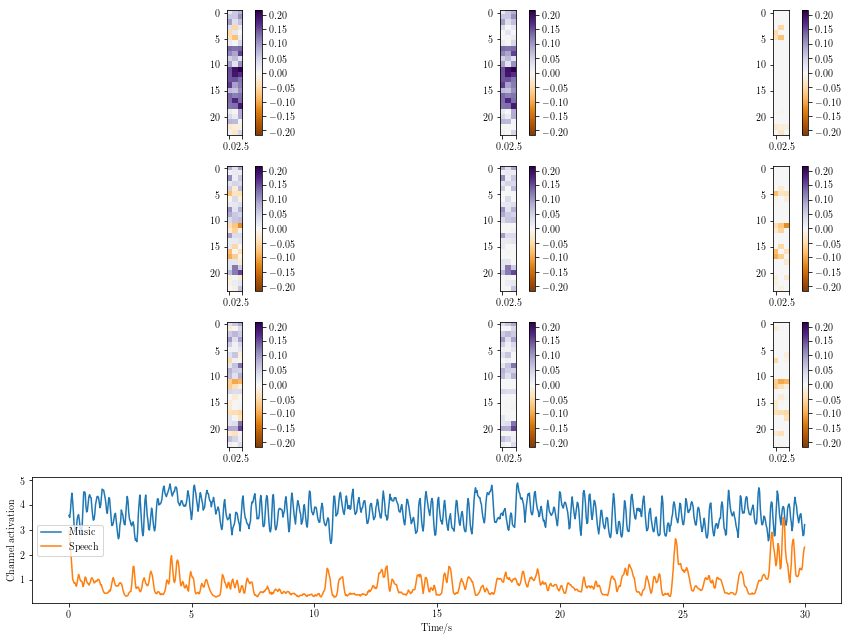

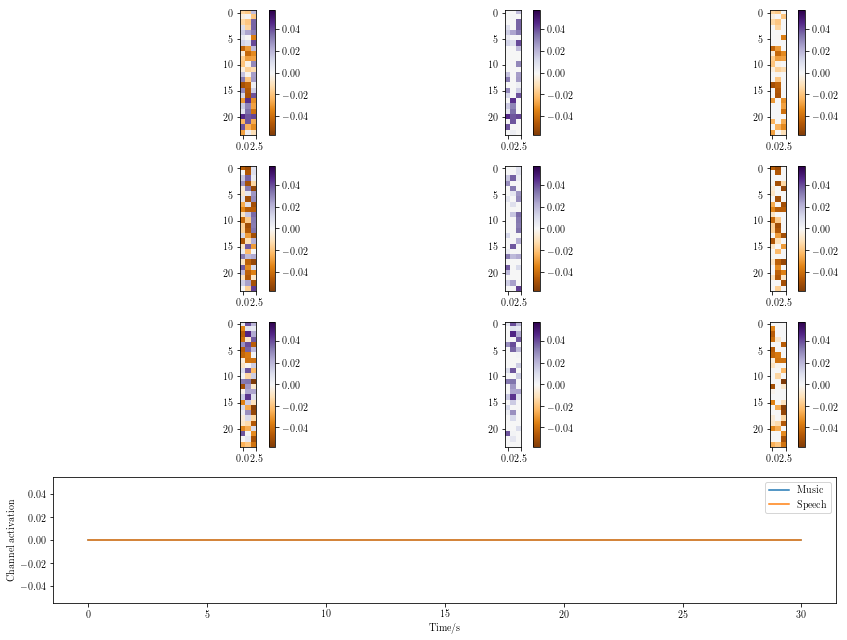

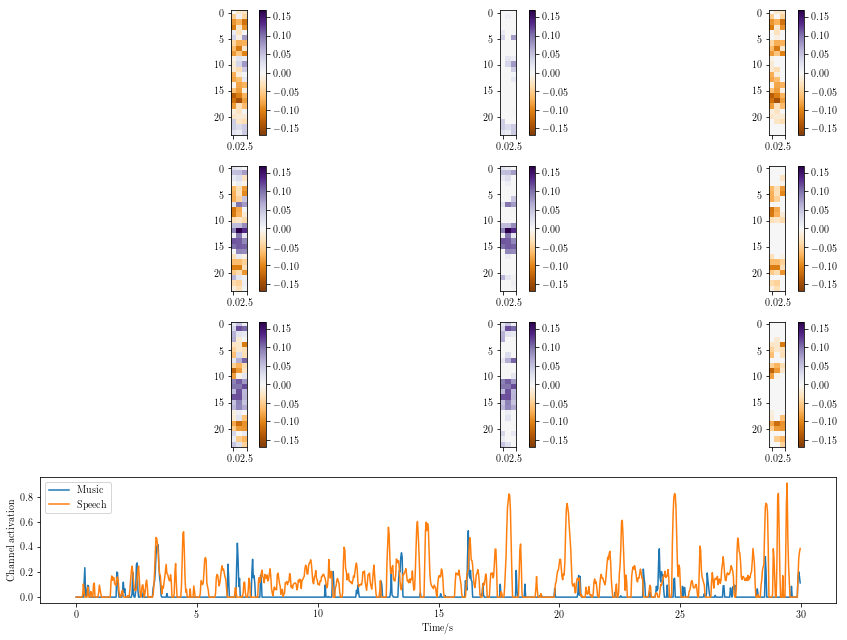

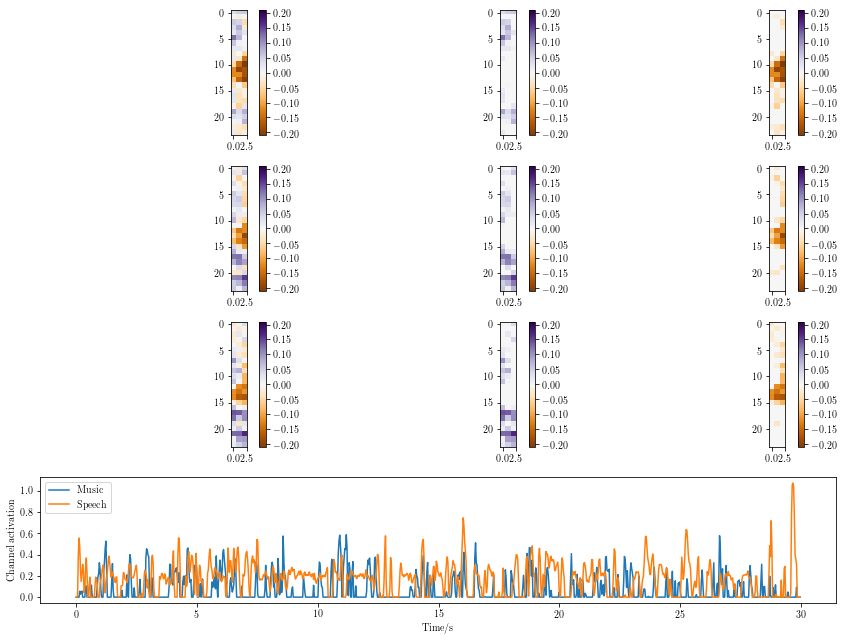

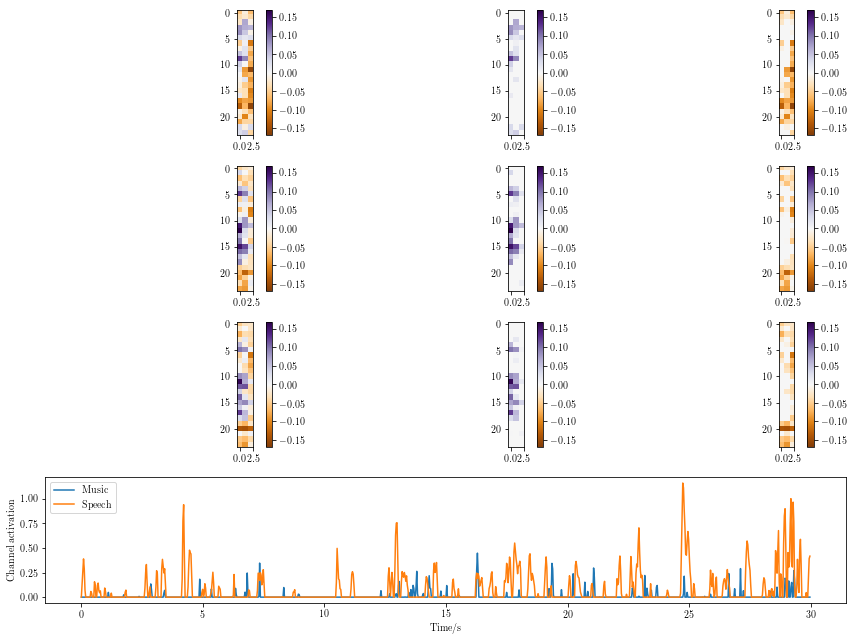

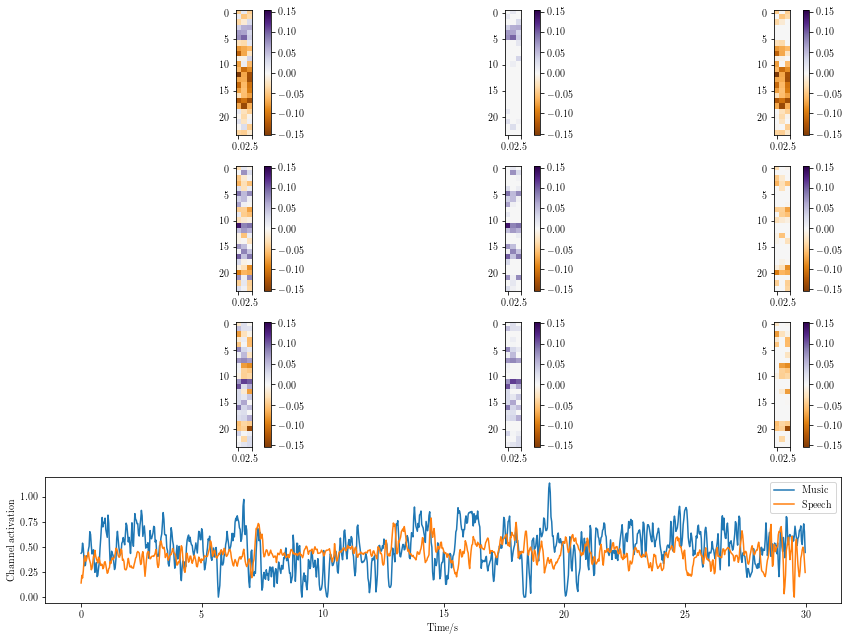

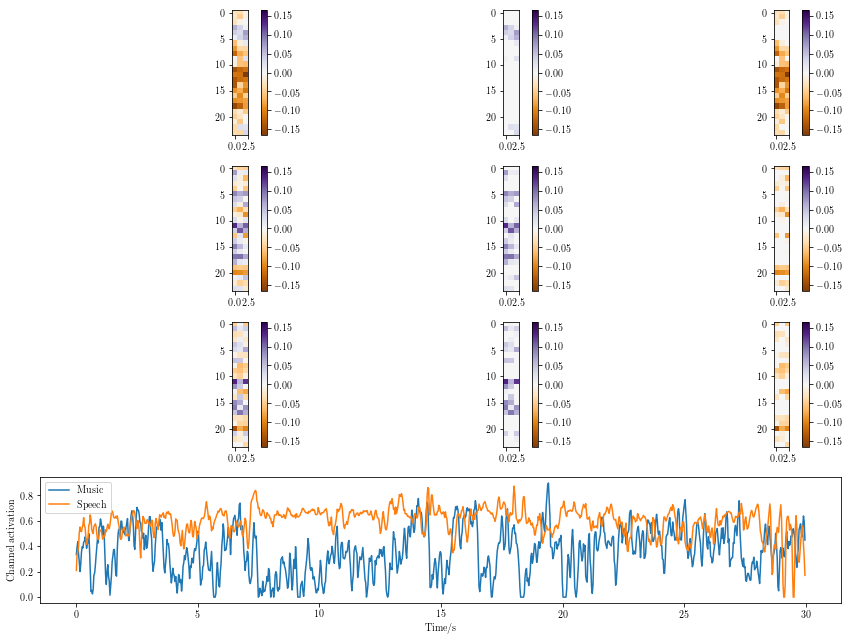

In [6]:
# evaluate the different channels
import matplotlib

os.makedirs("evaluate", exist_ok=True)

music_sample = Xtest[Ytest==MUSIC][0][None,...]
speech_sample = Xtest[Ytest!=MUSIC][0][None,...]

# plot the filters
if DATA == "SPECTRO":
    # get the first layer with weights:
    W_all, i = None, -1
    while W_all is None:
        i += 1
        try:
            W_all = model.layers[i].get_weights()[0]
        except: pass
        
    inspect_model = Model(inputs=model.input, outputs=model.layers[i].output)
    music_activation = inspect_model.predict(music_sample)[0,0]
    speech_activation = inspect_model.predict(speech_sample)[0,0]
    
    
    time = np.arange(0,30,30/music_activation.shape[0])
    
    
    num_output_channels = W_all.shape[-1]
    
    for output_channel in range(num_output_channels):
        W = W_all[:,:,:,output_channel]
        bound = np.max(np.absolute(W))
        norm = matplotlib.colors.Normalize(vmin=-bound, vmax=bound)

        num_filters = W.shape[-1]
        num_subplots = 3*num_filters

        fig = plt.figure(figsize=(12,9))

        for channel in range(num_filters):
            w_channel = W[:,:,channel]
            w_plus = np.maximum(w_channel, 0)
            w_minus = -np.maximum(-w_channel, 0)
            plt.subplot(num_filters+1,3,1 + channel*3)
            plt.imshow(w_channel, cmap="PuOr", norm=norm)
            plt.colorbar()

            plt.subplot(num_filters+1,3,2 + channel*3)
            plt.imshow(w_plus, cmap="PuOr", norm=norm)
            plt.colorbar()
            if MODEL=="LINEAR":
                plt.title("Evidence for music")

            plt.subplot(num_filters+1,3,3 + channel*3)
            plt.imshow(w_minus, cmap="PuOr", norm=norm)
            plt.colorbar()
            if MODEL=="LINEAR":
                plt.title("Evidence for speech")
        
        plt.subplot(num_filters+1, 1, num_filters+1)
        plt.plot(time, music_activation[:,output_channel], label="Music")
        plt.plot(time, speech_activation[:,output_channel], label="Speech")
        plt.xlabel("Time/s")
        plt.ylabel("Channel activation")
        plt.legend()

        plt.tight_layout()
        plt.savefig("evaluate/{}-spectro-filters-{}-channel{}.png".format(MODEL, filter_time_size, output_channel))
        plt.show()
